In [103]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt 
import pandas as pd
import random
#Taking graph of concerned place
graph=ox.graph_from_address("Bhopal",dist=20000)
#Prints graph details
print(graph)

MultiDiGraph with 86817 nodes and 218506 edges


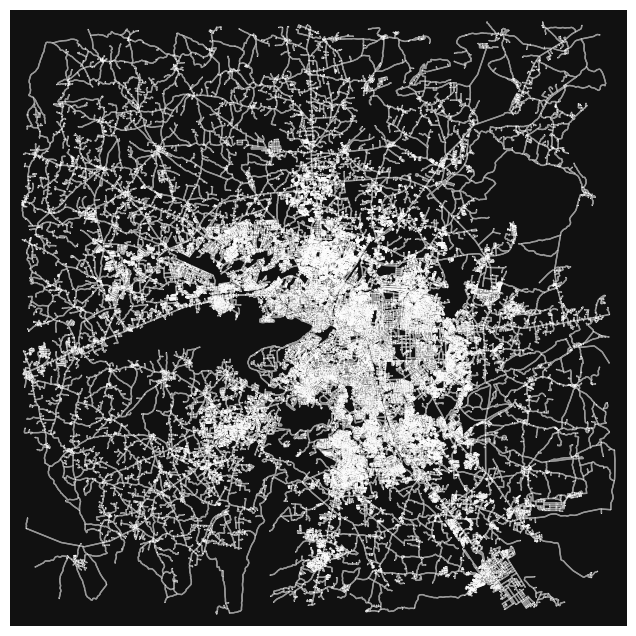

In [125]:
#Give the node size
nodesize=0.5
graph_proj=ox.project_graph(graph)
fig,ax=ox.plot_graph(graph_proj,node_size=nodesize)

In [111]:
import networkx as nx
import numpy as np

# Generate or load your graph (replace this with your graph)
G = graph

# Extract y-coordinate (latitude) from each node
node_y_coordinates = {node: G.nodes[node]['y'] for node in G.nodes()}

# Determine the range of y-coordinate values
min_y = min(node_y_coordinates.values())
max_y = max(node_y_coordinates.values())
y_range = max_y - min_y

# Number of partitions
num_partitions = 3

# Calculate interval size for each partition
interval_size = y_range / num_partitions

# Divide the nodes into partitions based on their y-coordinate values
partitioned_nodes = [[] for _ in range(num_partitions)]
for node, y_coord in node_y_coordinates.items():
    partition_index = min(int((y_coord - min_y) / interval_size), num_partitions - 1)
    partitioned_nodes[partition_index].append(node)

# Create subgraphs for each partition
partitioned_subgraphs = [G.subgraph(nodes) for nodes in partitioned_nodes]

# Example: Print number of nodes and edges in each subgraph
for i, subgraph in enumerate(partitioned_subgraphs):
    print(f"Partition {i + 1}:")
    print(f"Number of nodes: {subgraph.number_of_nodes()}")
    print(f"Number of edges: {subgraph.number_of_edges()}")
partitioned_subgraphs.reverse()  


Partition 1:
Number of nodes: 24428
Number of edges: 61039
Partition 2:
Number of nodes: 52138
Number of edges: 133027
Partition 3:
Number of nodes: 10251
Number of edges: 23812


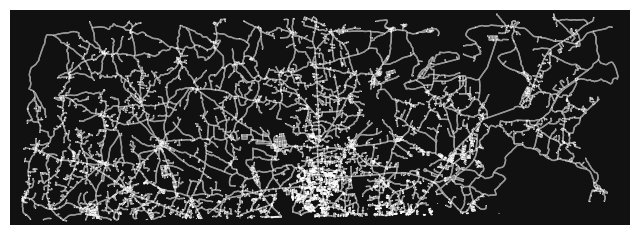

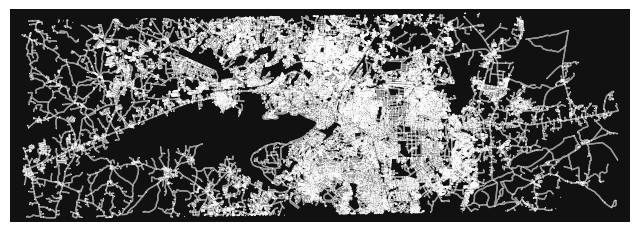

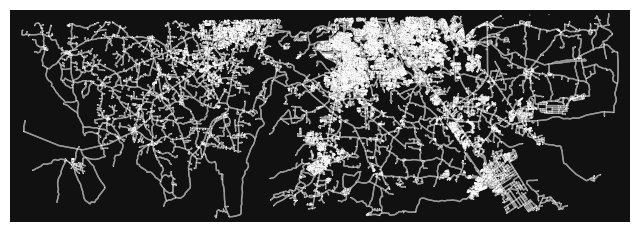

In [112]:
#Plotting subgraph from main graphs
for i in range(len(partitioned_subgraphs)):
    graph_proj=ox.project_graph(partitioned_subgraphs[i])
    fig,ax=ox.plot_graph(graph_proj,node_size=nodesize)

In [113]:
def randomcoords(G):
    nodes,edges=ox.graph_to_gdfs(G,nodes=True,edges=True)
    nodes['x']=nodes['x'].astype('double')
    #print(nodes)
    #print(edges)
    #Getting the extent of the graph
    xmax=nodes['x'].max()
    xmin=nodes['x'].min()
    ymax=nodes['y'].max()
    ymin=nodes['y'].min()
    #print(xmax,xmin,ymin,ymax)
    coords=(random.uniform(ymin+((ymax-ymin)/(2.5)),ymax-((ymax-ymin)/(2.5))),random.uniform(xmin+((xmax-xmin)/(2.5)),xmax-((xmax-xmin)/(2.5))))
    return coords

In [114]:
def cost(coords,G):
    coords_node,dist_1=ox.distance.nearest_nodes(G,X=coords[1],Y=coords[0],return_dist=True)
    #print(coords_node)
    #print(dist_1)
    #Find out the single shortest path
    dist_dict=nx.single_source_dijkstra_path_length(G,coords_node, cutoff=None, weight='length')
    values=list(dist_dict.values())
    cost=dist_1
    for i in range(len(values)):
        cost+=values[i]
    #print(cost)
    return cost

In [115]:
def get_chromosome_cost(chromosome,partitioned_subgraphs):
    summ=0
    i=0
    for x in chromosome:
        summ+=cost(x,partitioned_subgraphs[i])
        i=i+1
    return summ    
        

In [123]:
def plot_chromosomes(graph,chromosome):
    coordinates=[]
    for x in chromosome:
        coordinates.append(x)    
    fig, ax = ox.plot_graph(graph, figsize=(10, 10), show=False, close=False,node_size=nodesize)    
    # Plot the given coordinates
    for coord in coordinates:
        ax.scatter(coord[1], coord[0], c='red', s=100)  # longitude is x-axis, latitude is y-axis
    # Show the plot
    plt.show()

Chromosomes
[((23.388532874948556, 77.38688111963127), (23.268923863695175, 77.38460251077787), (23.149738968506437, 77.42249705695194)), ((23.376240743153918, 77.39827851736703), (23.266759438276598, 77.42411277478868), (23.137243037373292, 77.43151545276235)), ((23.374671677873568, 77.40764182142955), (23.255072170312122, 77.42493481482053), (23.144531963792694, 77.38163870560305)), ((23.38866710475621, 77.36478079975424), (23.261420942902227, 77.37097054956548), (23.1288028657638, 77.3860711753722)), ((23.378564852100077, 77.39158762976234), (23.254339438607605, 77.40816220111113), (23.132115843040683, 77.4396877357491)), ((23.37252520683817, 77.43087802898174), (23.269877119505452, 77.40149174010662), (23.149553649456532, 77.41089736331256)), ((23.370964398848123, 77.42256174701463), (23.25099444253231, 77.37129750715897), (23.13483703318969, 77.38661869035575)), ((23.3681202216849, 77.40101805383209), (23.267050071746663, 77.42554474356295), (23.14433586347481, 77.4087290496642)),

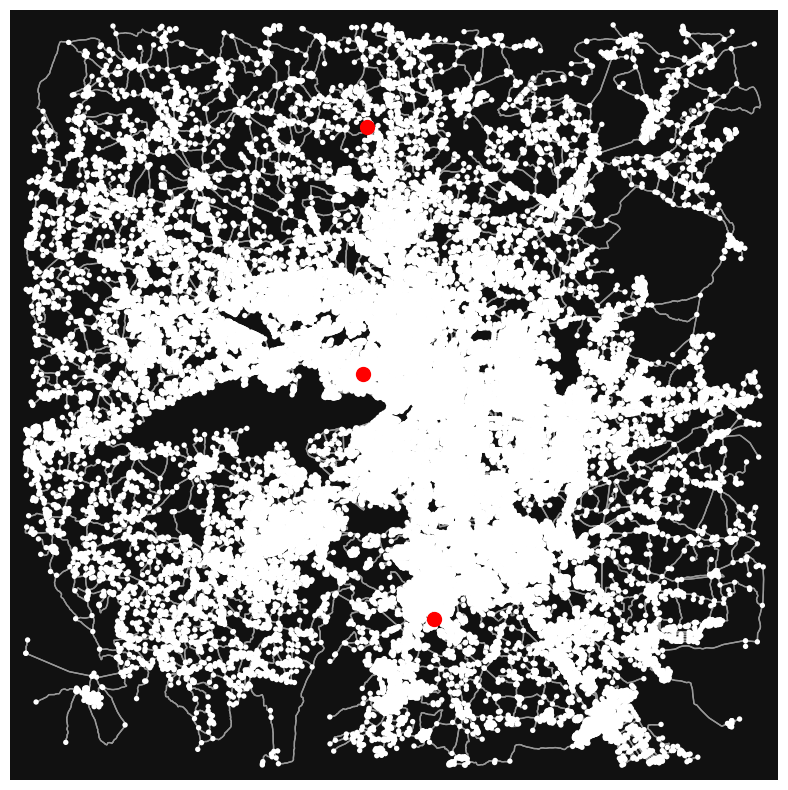

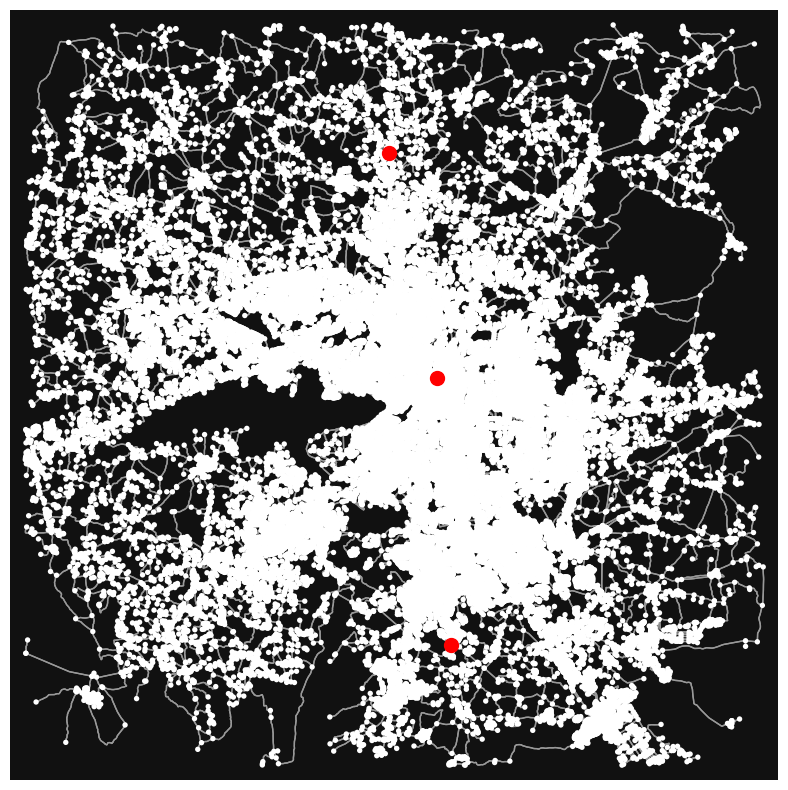

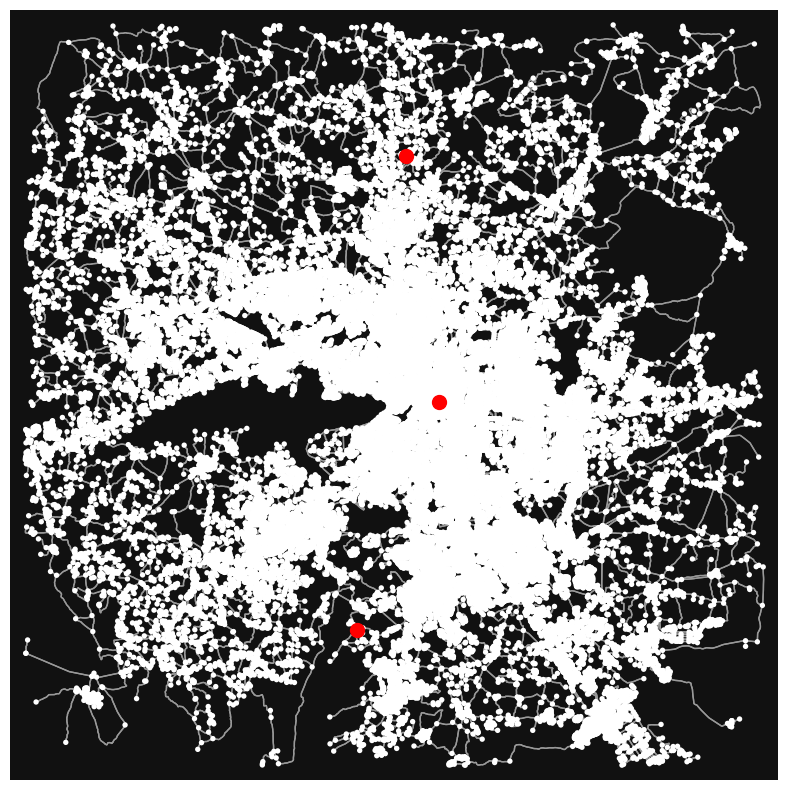

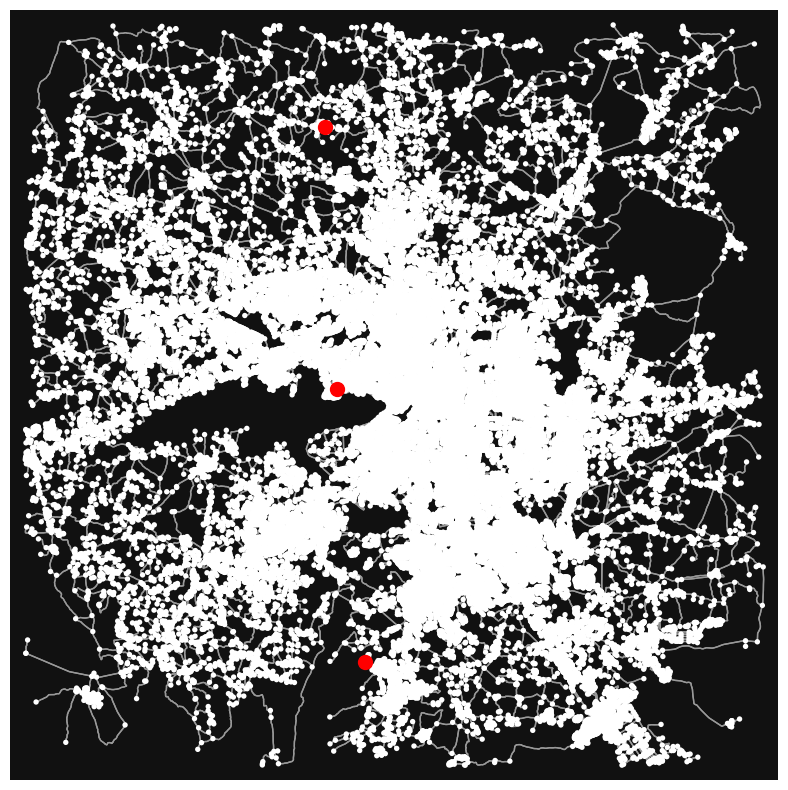

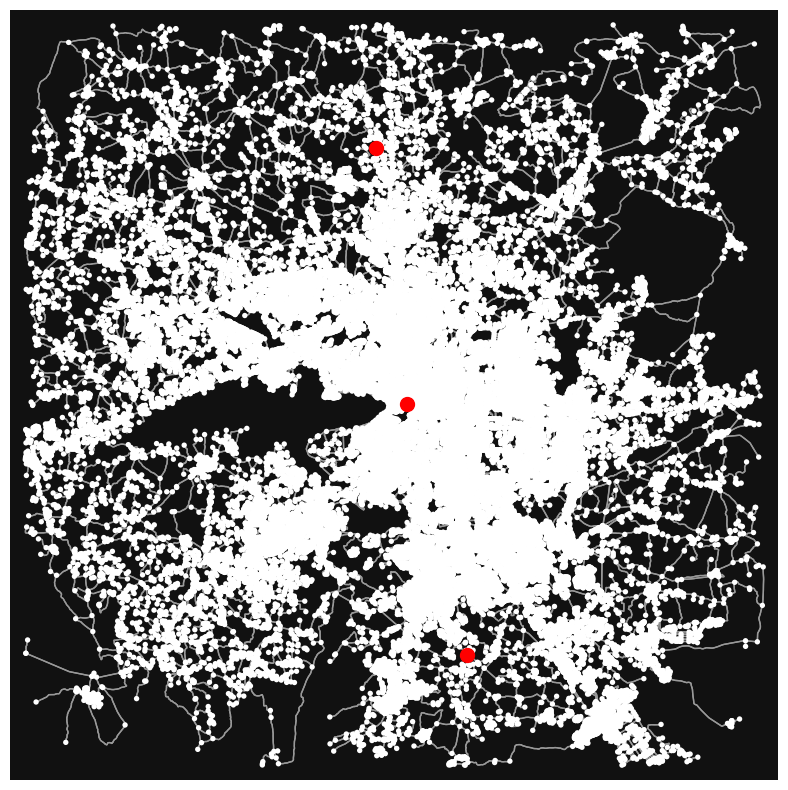

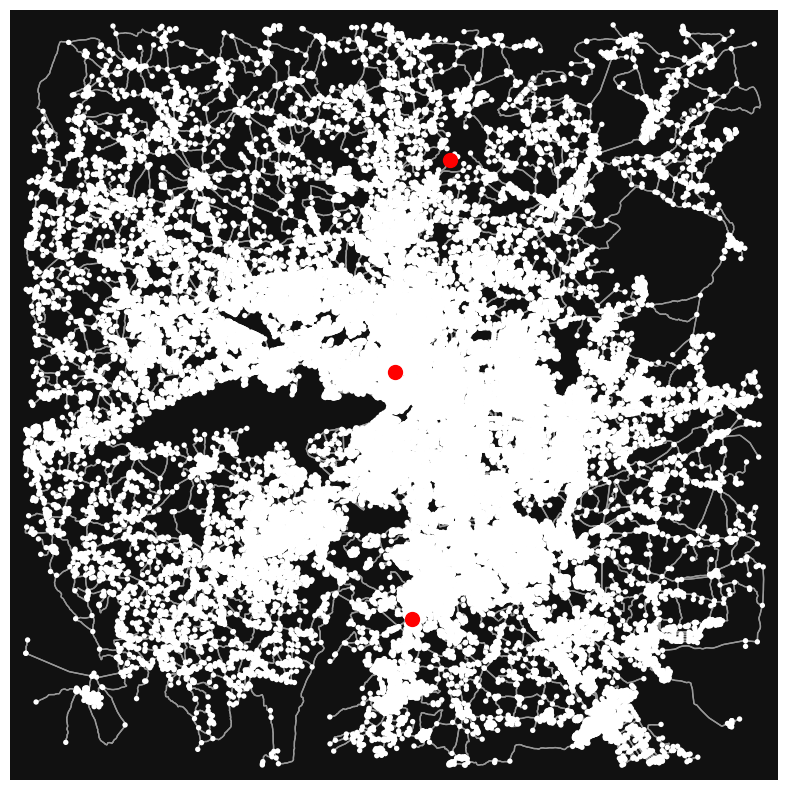

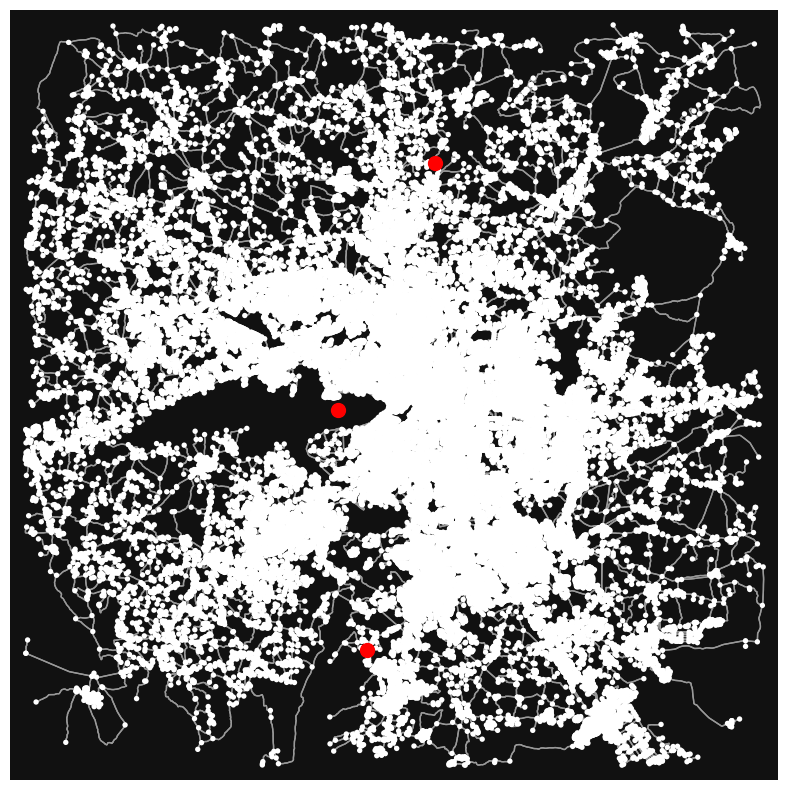

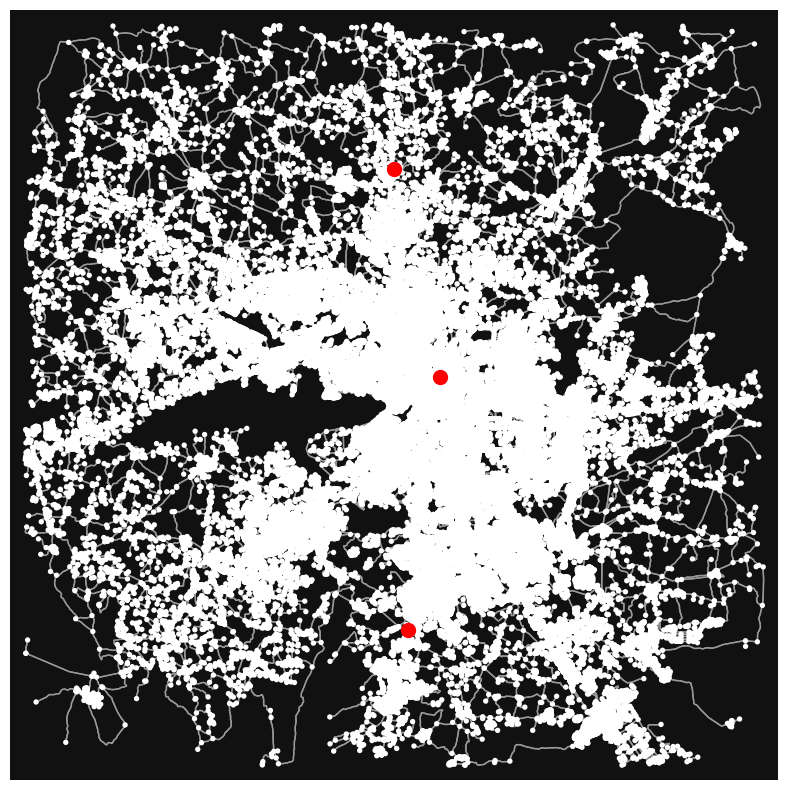

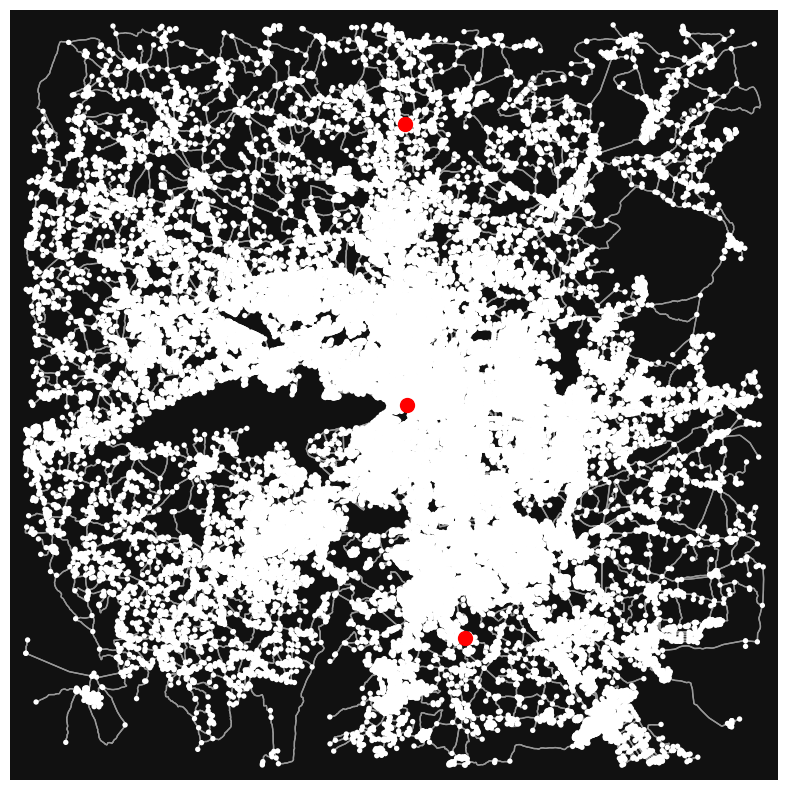

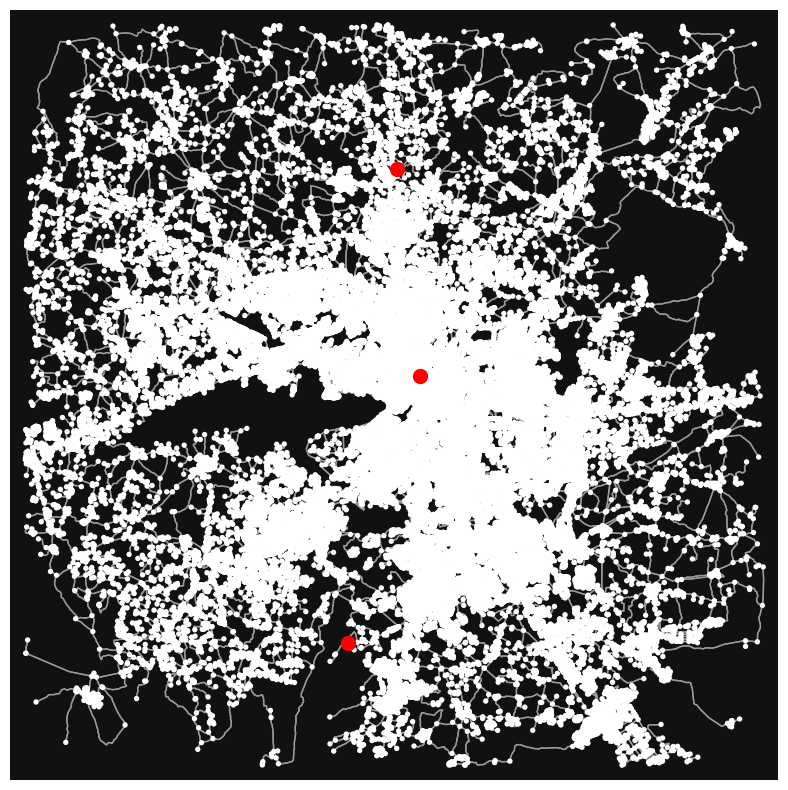

In [117]:
#Generate chromosomes
num_chromosomes=10
num_hospitals=num_partitions
chromosomes=[]
for i in range(num_chromosomes):
    coords_tuple=[]
    coords_tuple.append(randomcoords(partitioned_subgraphs[0]))
    for j in range(num_hospitals-1):
        coords=randomcoords(partitioned_subgraphs[j+1]) #We want coordinates in lattitude and longitude
        coords_tuple.append(coords)
    chromosomes.append(tuple(coords_tuple))
chromosomes_cost=[]
print('Chromosomes')
print(chromosomes)
for i in range(num_chromosomes):
    chromosomes_cost.append(get_chromosome_cost(chromosomes[i],partitioned_subgraphs))
print('Chromosomes cost')    
print(chromosomes_cost)
for i in range(num_chromosomes):
    plot_chromosomes(graph,chromosomes[i])


In [118]:
#ARRANGE SOLN SPACE ACCORDING TO COST
def arrange_space(soln_space,partitioned_subgraphs):
    cost_space=[]
    visited=[]
    arranged_soln_space=[]
    for i in range(len(soln_space)):
        visited.append(0)
    for i in range(len(soln_space)):
        cost_space.append(get_chromosome_cost(soln_space[i],partitioned_subgraphs))
   
    arranged_cost_space=sorted(cost_space)
   
       
    for i in range(len(soln_space)):
        for j in range(len(cost_space)):
            if arranged_cost_space[i]==cost_space[j] and visited[j]==0:
                visited[j]=1
                arranged_soln_space.append(soln_space[j])
    return arranged_soln_space  

The most optimal one is [(23.3681202216849, 77.40101805383209), (23.254339438607605, 77.40816220111113), (23.132115843040683, 77.4396877357491)]
798052945.7267032


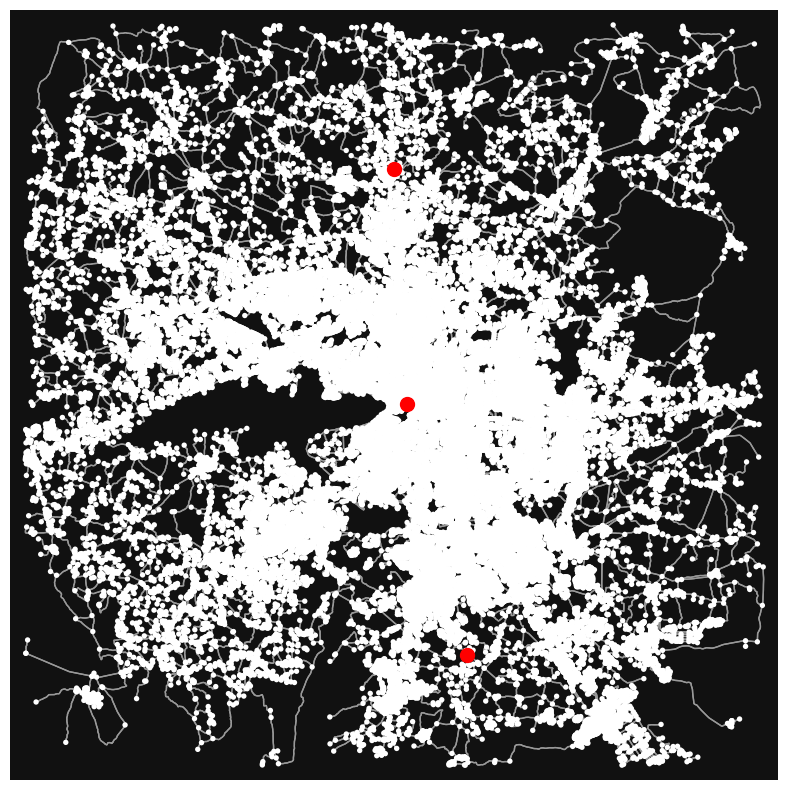

In [119]:
#Crossover between genes
def crossover(soln_space,slice,generation,partitioned_subgraphs):
    new_soln_space=[]
    old_soln_space=arrange_space(soln_space,partitioned_subgraphs)
    
    for j in range(generation):
        i=0
        while i<num_chromosomes-1:
            #Convert old_soln_space to list for easy access
                old_soln_list_1=list(old_soln_space[i])
                old_soln_list_2=list(old_soln_space[i+1])
                #it,s ok
                new_soln_space.append(old_soln_list_1[: slice]+old_soln_list_2[slice :])
                new_soln_space.append(old_soln_list_2[: slice]+old_soln_list_1[slice :])
                i+=2
        
        
        old_soln_space=arrange_space(new_soln_space,partitioned_subgraphs) 
        if j!=generation-1:
            new_soln_space=[]
        if j==generation-1:
            new_soln_space=arrange_space(new_soln_space,partitioned_subgraphs)
    
    return new_soln_space            
                
    
    
generation=10
slice=1
#print(crossover(chromosomes,slice,generation,graph))

k=crossover(chromosomes,slice,generation,partitioned_subgraphs)[0]
print("The most optimal one is",k)
print(get_chromosome_cost(k,partitioned_subgraphs))
plot_chromosomes(graph,k)


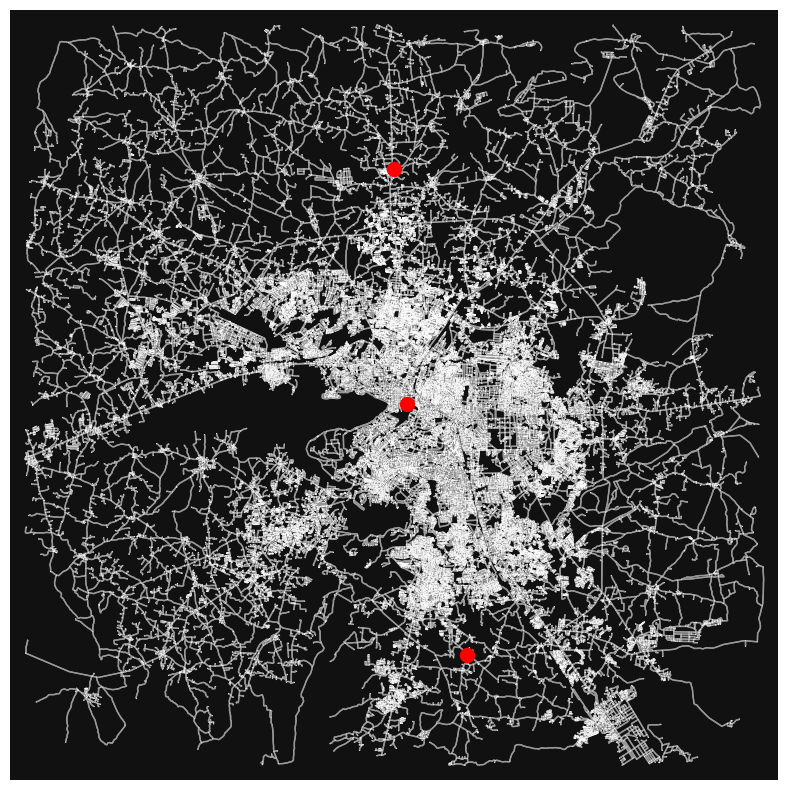

In [126]:
plot_chromosomes(graph,k)